# 1. Required libraries

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 2. Data Acquisition

In [3]:
# Install kaggle
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

# Make directory for Kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Brain MRI dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 941MB/s]


In [4]:
!unzip brain_tumor_dataset.zip -d brain_mri

Archive:  brain_tumor_dataset.zip
  inflating: brain_mri/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_mri/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_mri/brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_mri/brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_mri/brain_tumor_dat

# 3. Data Preparation

In [5]:
!pip install split-folders
import splitfolders

# Input dataset (yes/no folders)
input_folder = "brain_mri/brain_tumor_dataset"

# Output dataset with train/val/test
splitfolders.ratio(input_folder, output="brain_mri/split_data",
                   seed=42, ratio=(0.7, 0.2, 0.1))


Copying files: 253 files [00:00, 4223.11 files/s]


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "brain_mri/split_data/train"
val_dir   = "brain_mri/split_data/val"
test_dir  = "brain_mri/split_data/test"

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


# 4. Designing the architecture

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 5. DNN Report

In [8]:
# * Total number of trainable parameters :
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Compiling and Training the model

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [10]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 859ms/step - accuracy: 0.5393 - loss: 1.1457 - val_accuracy: 0.8148 - val_loss: 0.4766
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7139 - loss: 0.5649 - val_accuracy: 0.8519 - val_loss: 0.4209
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 796ms/step - accuracy: 0.8301 - loss: 0.4937 - val_accuracy: 0.8519 - val_loss: 0.3570
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7888 - loss: 0.4332 - val_accuracy: 0.8519 - val_loss: 0.3300
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8390 - loss: 0.3981 - val_accuracy: 0.8519 - val_loss: 0.3239
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8934 - loss: 0.2930 - val_accuracy: 0.8519 - val_loss: 0.2995
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 766ms/step - accuracy: 0.9195 - loss: 0.2441 - val_accuracy: 0.9259 - val_loss: 0.3399
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9510 - loss: 0.1766 - val_accuracy: 0.8889 - val_loss: 0.2697
Epoch 9

# 7. Test the model

In [11]:
loss, acc = model.evaluate(test_data)
print(f"Test Loss: {loss*100:.2f}%")
print(f"Test Accuracy: {acc*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.8889 - loss: 0.2978
Test Loss: 29.78%
Test Accuracy: 88.89%


# 8. Report the result
1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.

Target classes: {'no': 0, 'yes': 1}


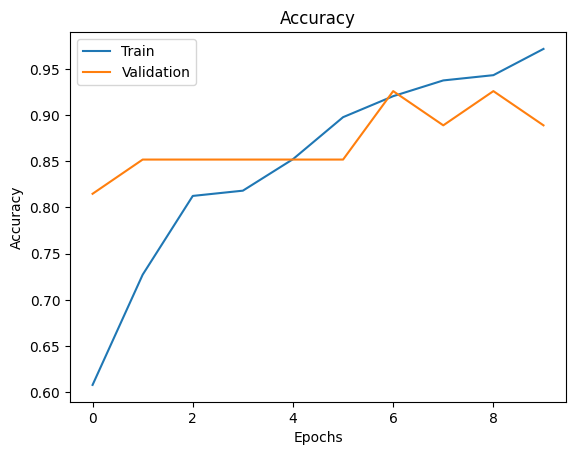

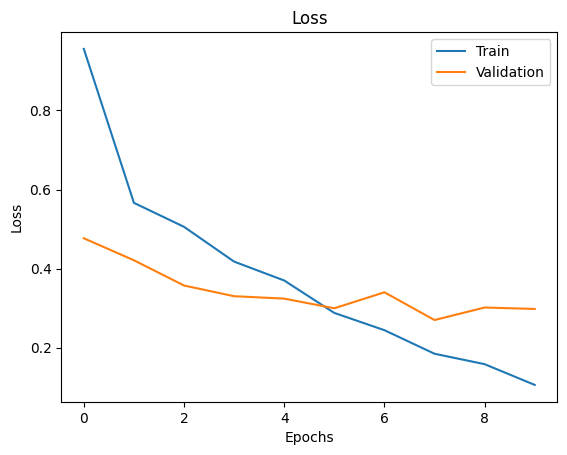

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


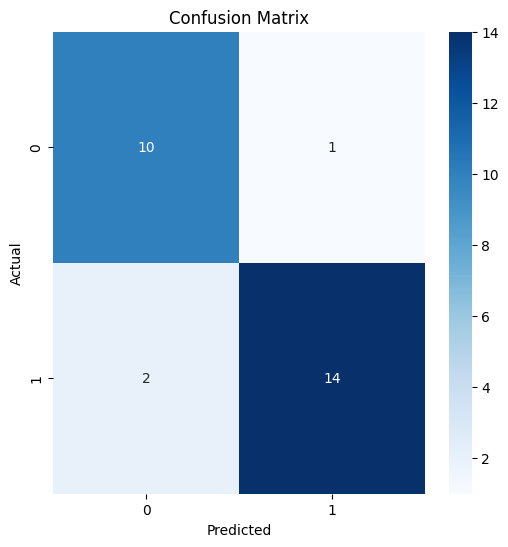

              precision    recall  f1-score   support

          no       0.83      0.91      0.87        11
         yes       0.93      0.88      0.90        16

    accuracy                           0.89        27
   macro avg       0.88      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



In [15]:
##---------Type the code below this line------------------##

classes = train_data.class_indices
print("Target classes:", classes)

# 1. Plot the training and validation accuracy history
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. Plot the training and validation loss history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Report testing accuracy and loss (already shown above)
# 4. Show Confusion Matrix for testing dataset
Y_pred = model.predict(test_data)
y_pred = np.where(Y_pred > 0.5, 1, 0)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. Report values for accuracy, precision, recall, F1
print(classification_report(y_true, y_pred, target_names=list(classes.keys())))


# 9. Real Life Example

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

#img_path = "brain_mri/brain_tumor_dataset/no/10 no.jpg"  # example image
img_path = "images5.jpg"  # example image
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]

if prediction > 0.5:
    print("Tumor Detected")
    print(f"Confidence: {prediction*100:.2f}%")
else:
    print("No Tumor Detected")
    print(f"Confidence: {(1-prediction)*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Tumor Detected
Confidence: 60.23%
